# Trabajo Práctico 3
*   Arelis Picado
*   Diego Solís
*   Isaac Vargas

# 1. Optimización de funciones

Para las siguientes funciones:

$$
f_{0}(x, y) = x^{2} + y^{2}
$$

$$
f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2}
$$

$$
f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy
$$

con $x, y \in [-10, 10]$.

Para todos los algoritmos, ejecútelos por $P = 25$ iteraciones e inicialice las soluciones en el rango $x, y \in [-10, 10]$.



# Código Auxiliar

En esta sección se presenta todo el código auxiliar utilizado en el desarrollo de la tarea.

In [43]:
# Imported libraries
import numpy as np
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import torch
%pip install optuna
import optuna
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
# Define our functions
def f_0(x, y):
    """
    @brief Function f_0 computes the sum of the squares of its inputs.

    @param x The first input value.
    @param y The second input value.

    @return The result of the function f_0: f_0(x, y) = x^2 + y^2.
    """
    return x**2 + y**2

def f_1(x, y):
    """
    @brief Function f_1 computes a specific mathematical expression involving its inputs.

    The expression is defined as:
    f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2

    @param x The first input value.
    @param y The second input value.

    @return The result of the function f_1.
    """
    term1 = (1.5 - x + x * y)**2
    term2 = (2.25 - x + x * y**2)**2
    term3 = (2.625 - x + x * y**3)**2
    return term1 + term2 + term3

def f_2(x, y):
    """
    @brief Function f_2 computes a specific quadratic expression of its inputs.

    The expression is defined as:
    f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy

    @param x The first input value.
    @param y The second input value.

    @return The result of the function f_2.
    """
    return 0.26 * (x**2 + y**2) - 0.48 * x * y

functions = [f_0, f_1, f_2]

latex_functions = [
    r'$f_0(x, y) = x^2 + y^2$',
    r'$f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$',
    r'$f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$'
]

Creamos un estudio para optimizar usando Optuna

In [45]:
def run_study(optimizer_func, func, eq, n_trials=50, verbose=False):
    """
    @brief Runs an optimization study using a given optimizer function and objective function.

    @param optimizer_func The optimization function to be used (e.g., RMSprop, Gradient Descent).
    @param func The function to minimize (f_0, f_1, f_2).
    @param eq The equation in LaTeX form for display purposes.
    @param n_trials The number of trials to run for hyperparameter tuning (default is 50).
    @param verbose A flag to control verbosity of logging (default is False).

    @return The Optuna study object containing the optimization results.
    """
    if verbose == False:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    print(f"\nOptimizing hyperparameters for {eq} using {optimizer_func.__name__}...")

    # Create a study
    study = optuna.create_study(direction='minimize')

    # Optimize the objective function using the specified optimizer
    study.optimize(lambda trial: optimizer_func(trial, func), n_trials=n_trials)

    return study


def plot_study(func_name: str, losses: list, best_params: dict, best_value: float, eq: str, save: bool = False) -> None:
    """
    @brief Plots the learning curve of the optimization process and displays best hyperparameters and loss.

    @param func_name The name of the function being optimized.
    @param losses A list of loss values recorded during the optimization process.
    @param best_params A dictionary containing the best hyperparameters found.
    @param best_value The best loss value found during optimization.
    @param eq The equation in LaTeX form for display purposes.
    @param save A flag to control whether to save the plot as a PNG file (default is False).
    """
    print(f"Best hyperparameters for {func_name}: {best_params}")
    print(f"Best loss for {func_name}: {best_value}")

    # Create figure with a light gray facecolor
    fig, ax = plt.subplots(figsize=(10, 6))

    # Change the background color of the plot area (axes)
    ax.set_facecolor('#f7f7fc')  # light lavender color for plot area background

    # Plot the learning curve with a smooth line
    ax.plot(range(1, len(losses) + 1), losses, color='#494980', linewidth=2, label=f'{func_name} loss')

    # Highlight the best value (orange point)
    ax.scatter(len(losses), best_value, color='#fca349', zorder=5, s=100, label=f'Best Loss: {best_value:.4e}')

    # Add grid with lighter color
    ax.grid(True, linestyle='--', alpha=0.3)

    # Title and labels with modern font
    ax.set_title(f'Learning Curve for {eq}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    # Place the legend inside the plot in the upper right corner
    ax.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white')

    # Set ticks styling
    ax.tick_params(axis='both', labelsize=12)

    # Tight layout for clean spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Optionally save the figure as a high-resolution PNG file
    if save:
        plt.savefig(f'{func_name}_learning_curve.png', dpi=300, bbox_inches='tight')

Gráfica del proceso de optimización para diferentes estudios y su línea de aprendizaje.

In [46]:
def plot_optimization_path(func, eq, losses, visited_points, save=False):
    """
    @brief Visualizes the points visited by the optimizer during its run, overlaid on a contour plot.

    @param func The function being optimized, which takes two inputs (X, Y).
    @param eq The equation in LaTeX form for display purposes, used in the learning curve title.
    @param losses A list of loss values over iterations, representing the learning curve.
    @param visited_points A list of tuples (x, y) representing points visited by the optimizer.
    """
    func_name = func.__name__

    x = np.linspace(-10, 10, 400)
    y = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), facecolor='#f7f7fc')

    # Plot the contour map of the function
    cp = ax[0].contourf(X, Y, Z, levels=50, cmap='Blues')
    ax[0].clabel(cp, inline=True, fontsize=8)

    # Plot the path of the optimizer (points visited)
    visited_points = np.array(visited_points)
    ax[0].plot(visited_points[:, 0], visited_points[:, 1], color='#fca349', marker='o', label='Optimization Path')

    # Annotate and format the plot
    ax[0].set_title(f'Optimization Path for {func_name}', fontsize=14)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].grid(True, linestyle='--', alpha=0.3)
    ax[0].legend()

    # Plot the learning curve (loss vs. iteration)
    ax[1].set_facecolor('#f7f7fc')
    ax[1].plot(range(1, len(losses) + 1), losses, color='#494980', linewidth=2, label=f'{func_name} Loss')
    ax[1].scatter(len(losses), losses[-1], color='#fca349', zorder=5, s=100, label=f'Final Loss: {losses[-1]:.4e}')

    # Annotate and format the learning curve plot
    ax[1].set_title(f'Learning Curve for {eq}', fontsize=14)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')
    ax[1].grid(True, linestyle='--', alpha=0.3)
    ax[1].legend()

    # Tight layout for better spacing
    plt.tight_layout()

    if save:
        plt.savefig(f'./imgs/plot_optimization_path_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [47]:
def contour_and_learning(studies):
    """
    @brief This function retrieves the best trial's losses and visited points from each study
    and calls the plotting function to visualize the results.

    @param studies A list of Optuna study objects containing the optimization results.
    """
    # Retrieve the best trial's losses and visited points
    for std, func, eq in zip(studies, functions, latex_functions):
        best_trial = std.best_trial
        losses = best_trial.user_attrs['losses']
        visited_points = best_trial.user_attrs['visited_points']

        # Plot the optimization path and learning curve
        plot_optimization_path(func=func,
                                eq=eq,
                                losses=losses,
                                visited_points=visited_points)

Código para el Descenso de Gradiente

In [48]:
def gradient_descent(trial, func, initial_point=None, max_iterations=25):
    """
    @brief Implements Gradient Descent to minimize the given function.

    @param trial The Optuna trial object to suggest hyperparameters.
    @param func The function to minimize (like f_0, f_1, f_2).
    @param initial_point Optional initial point for the parameters (default is None).
    @param max_iterations Maximum number of iterations (default is 25).

    @return Final loss value after optimization.
    """

    # Suggest hyperparameters to tune (only the learning rate in Gradient Descent)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

    # Initialize parameters (2 parameters: x and y)
    if initial_point is not None:
        params = torch.tensor(initial_point, dtype=torch.float32, requires_grad=True)
    else:
        params = torch.randn((2, 1), requires_grad=True)

    # Record losses for plotting the learning curve
    losses = []
    visited_points = []

    max_iterations = 25
    for _ in range(max_iterations):
        if params.grad is not None:
            params.grad.zero_()

        # Compute loss (your function needs to accept torch tensors)
        loss = func(params[0], params[1])

        # Backward pass to compute gradients
        loss.backward()

        # Manually update parameters using Gradient Descent
        if params.grad is not None:
            with torch.no_grad():
                params -= lr * params.grad  # Basic gradient descent update rule

        # Record the loss for this iteration
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

    # Save losses for later visualization
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    # Return the final loss value
    return loss.item()

# Ejercicio #1

1. **(20 puntos)** Grafique las funciones usando la función `meshgrid` y `contour`, y distinga si las funciones son convexas o no, los puntos mínimos y las regiones o puntos silla.

**Solución:** La implementación permite elegir si se presenta en log scale o no para poder facilitar las visualizaciones. En este caso, es más sencillo poder ver el comportamiento de las funciones con esta variable activada. También se modifica de `contour` a `contourf` pues esta última ofrece un mejor resultado visual.

In [49]:
def plot_contours(func, func_name, cmap='magma', levels=20, log_scale=False, save=False):
    """
    @brief Creates and displays a filled contour plot for a given mathematical function.

    @param func The mathematical function to evaluate, which takes two inputs (X, Y).
    @param func_name The name of the function being plotted, used in the title.
    @param cmap The colormap to use for the plot (default is 'magma').
    @param levels The number of contour levels to display (default is 20).
    @param log_scale A flag to indicate if a logarithmic scale should be applied to the function values (default is False).
    @param save A flag to control whether to save the plot as a PNG file (default is False).
    """
    x = np.linspace(-10, 10, 400)
    y = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(x, y)

    # Evaluate the function for the meshgrid
    Z = func(X, Y)

    # Handle log scale if required
    if log_scale:
        Z = np.log(np.abs(Z) + 1)  # Adding 1 to avoid log(0) issues

    # Create the filled contour plot
    plt.figure(figsize=(12, 9))
    cp = plt.contourf(X, Y, Z, levels=levels, cmap=cmap)

    # Add title and labels
    plt.title(f'Improved Contour Plot for {func_name}')
    plt.xlabel('x')
    plt.ylabel('y')

    # Show color bar
    plt.colorbar(cp)

    # Save
    if save:
        plt.savefig(f'./imgs/improved_contour_plot_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

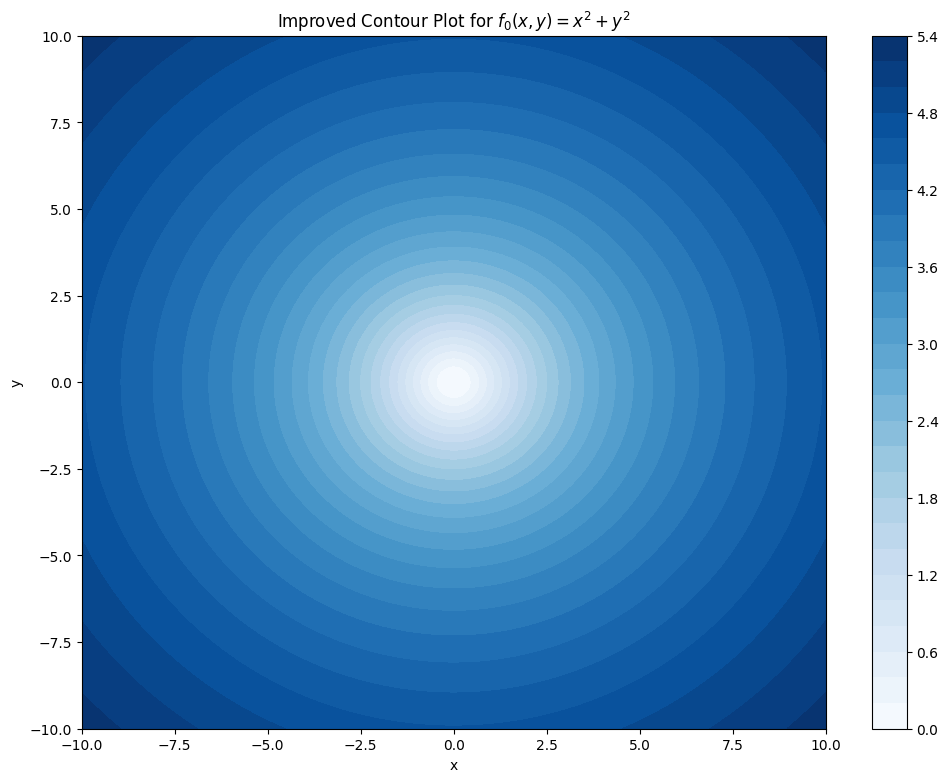

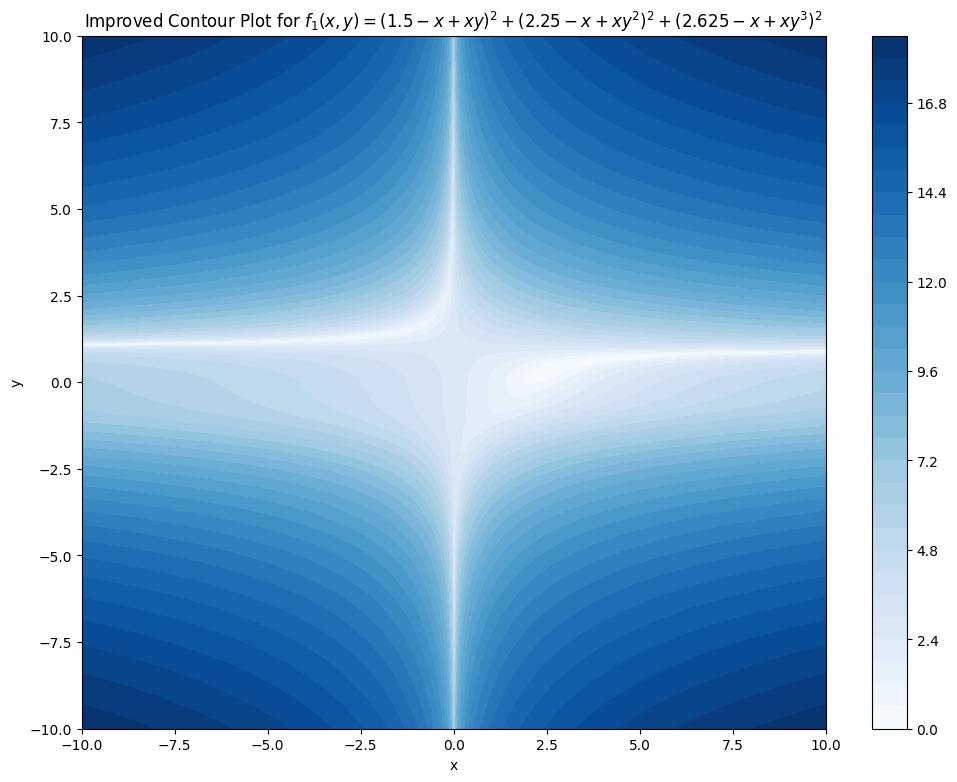

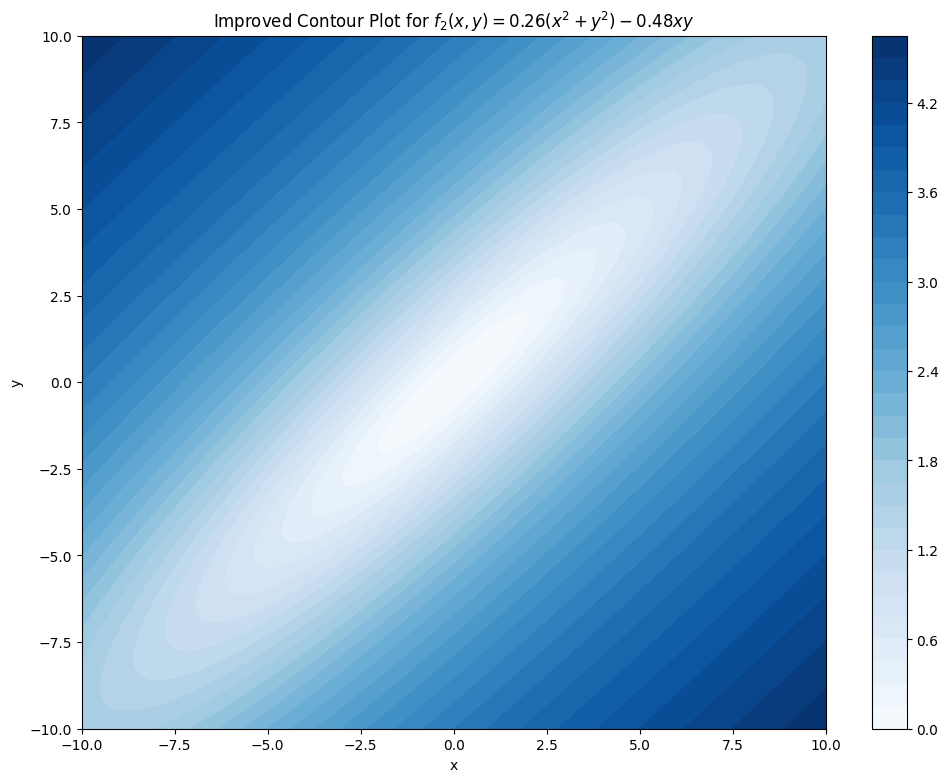

In [50]:
for f, eq in zip(functions, latex_functions):
    plot_contours(f, func_name=eq, levels=30, log_scale=True, save=False, cmap='Blues')

# REVISAR ANTES DE ENVIAR
* La función f_0 es convexa, como se puede ver del plot. Esta función sería, en tres dimensiones, como un bolw
* La función f_1 tiene un punto de silla por los cambios bruscos en el plot de contorno
* La función f_2 también es convexa

**EXTRA:** Con plots de 3D se puede visualizar aún mejor

In [51]:
def plot_3d_surface(func, func_name, cmap='viridis', save=False):
    x = np.linspace(-50, 50, 400)
    y = np.linspace(-50, 50, 400)
    X, Y = np.meshgrid(x, y)

    # Evaluate the function for the meshgrid
    Z = func(X, Y)

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')

    # Add title and labels
    ax.set_title(f'3D Surface Plot for {func_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')

    # Show color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    if save:
        plt.savefig(f'./imgs/plot_3d_surface_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

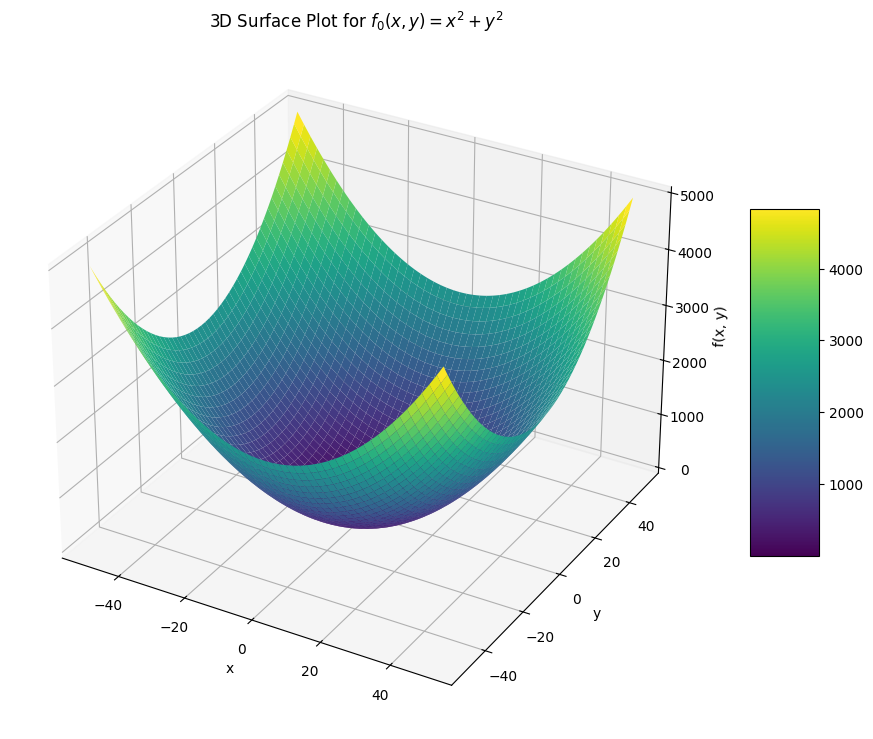

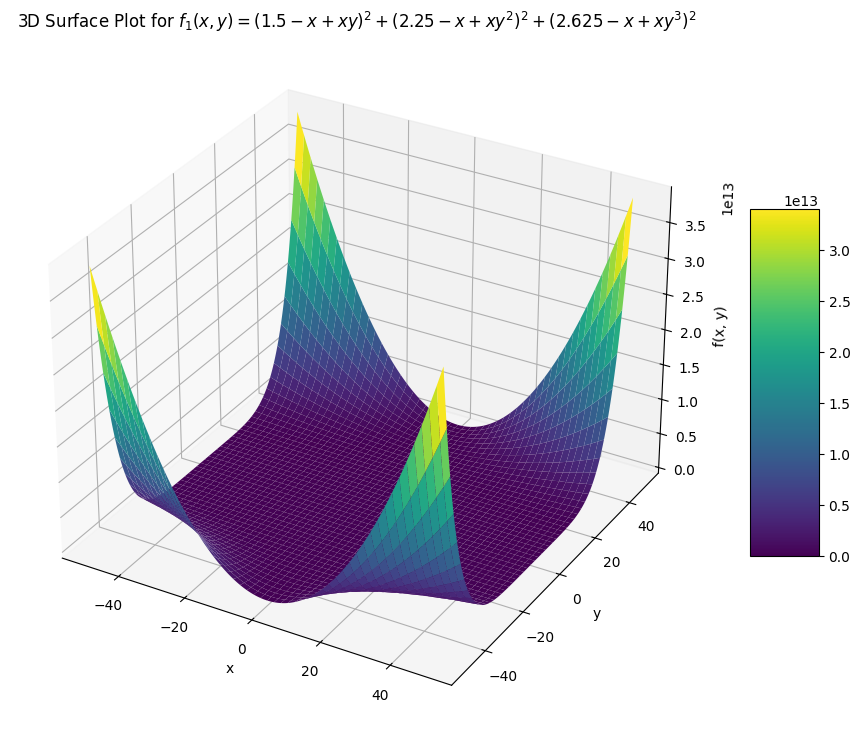

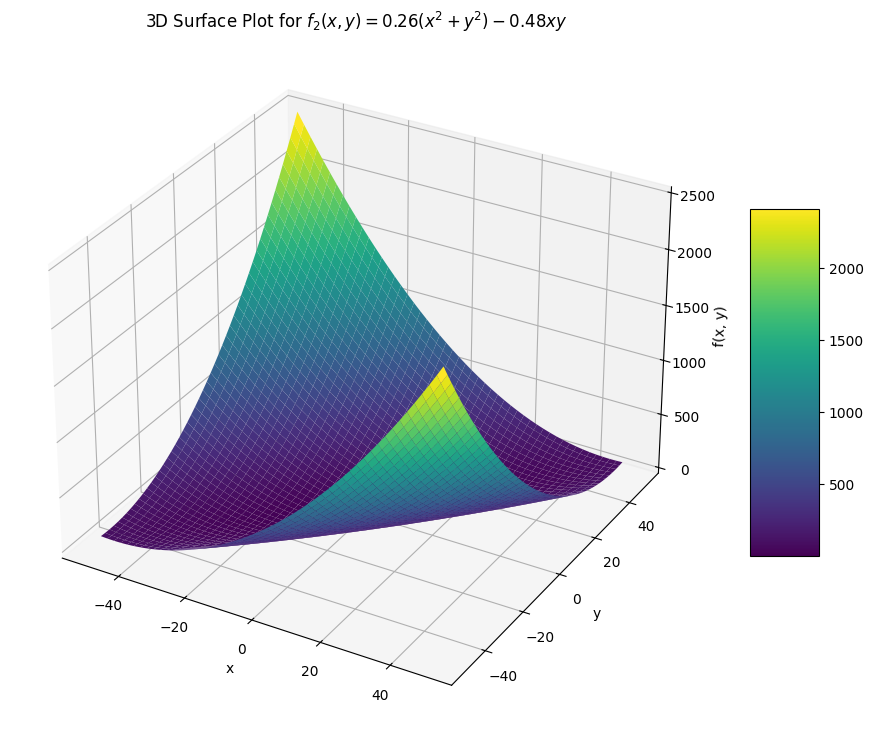

In [52]:
for f, eq in zip(functions, latex_functions):
    plot_3d_surface(f, eq)

# Ejercicio #2

**(40 puntos)** Implemente el algoritmo del RMS prop. para encontrar el punto mínimo en PyTorch, de la forma más vectorial posible. Implemente las siguientes pruebas.

In [62]:
def RMSprop(trial, func, initial_point=None, max_iterations=25):
    """
    @brief Implements the RMSprop optimization algorithm to minimize the given function.

    @param trial The Optuna trial object to suggest hyperparameters.
    @param func The function to minimize (like f_0, f_1, f_2).
    @param initial_point Optional initial point for the parameters (default is None).
    @param max_iterations Maximum number of iterations (default is 25).

    @return Final loss value after optimization.
    """

    # Suggest hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 0.9, 0.999)
    eps = 1e-8

    # Initialize parameters
    if initial_point is not None:
        params = torch.tensor(initial_point, dtype=torch.float32, requires_grad=True)
    else:
        params = torch.randn((2, 1), requires_grad=True)

    avg_sq_grad = torch.zeros_like(params)

    # Record losses for plotting the learning curve
    losses = []
    visited_points = []

    for _ in range(max_iterations):
        if params.grad is not None:
            params.grad.zero_()

        # Compute loss
        loss = func(params[0], params[1])

        # Backpropagation
        loss.backward()

        # Manually update parameters using RMSprop
        if params.grad is not None:
          with torch.no_grad():
              avg_sq_grad = alpha * avg_sq_grad + (1 - alpha) * params.grad**2
              params -= lr * params.grad / (torch.sqrt(avg_sq_grad) + eps)

        # Keep the loss
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

    # Save losses
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    return loss.item()

##### a) Para cada función, calibre los hiperparámetros del algoritmo, mostrando el proceso de calibrado usando las gráficas de aprendizaje, y reporte los mejores valores encontrados.

1. Realice el proceso de calibración usando un framework como optuna https://optuna.org/ o weights and biases https://wandb.ai/site. Reporte los mejores valores encontrados.

In [63]:
torch.manual_seed(42)

Optimización de $f_{0}(x, y) = x^{2} + y^{2}$

In [64]:
RMS_opt = []

study_results_f_0 = run_study(RMSprop, functions[0], latex_functions[0])
RMS_opt.append(study_results_f_0)


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using RMSprop...


Best hyperparameters for f_0: {'lr': 0.07019734848923768, 'alpha': 0.9973100285581473}
Best loss for f_0: 5.899914950316064e-40


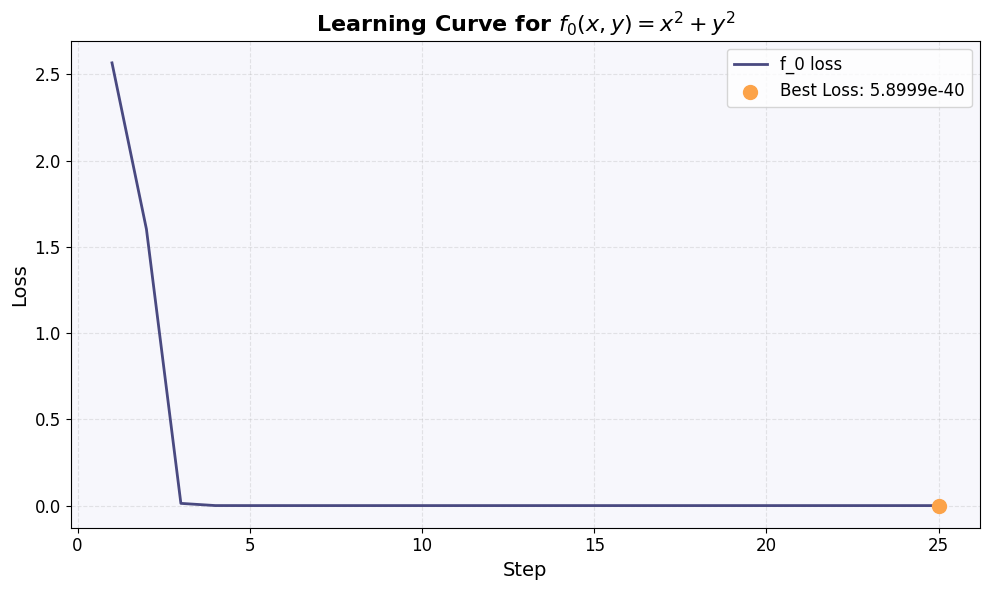

In [65]:
plot_study(func_name=functions[0].__name__,
           losses= study_results_f_0.best_trial.user_attrs['losses'],
           best_params= study_results_f_0.best_params,
           best_value= study_results_f_0.best_value,
           eq =latex_functions[0])

Optimización de $ f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2} $

In [37]:
study_results_f_1 = run_study(RMSprop, functions[1], latex_functions[1])
RMS_opt.append(study_results_f_1)



Optimizing hyperparameters for $f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$ using RMSprop...


Best hyperparameters for f_1: {'lr': 0.043460120925789755, 'alpha': 0.948243182741525}
Best loss for f_1: 3.7408433854579926e-05


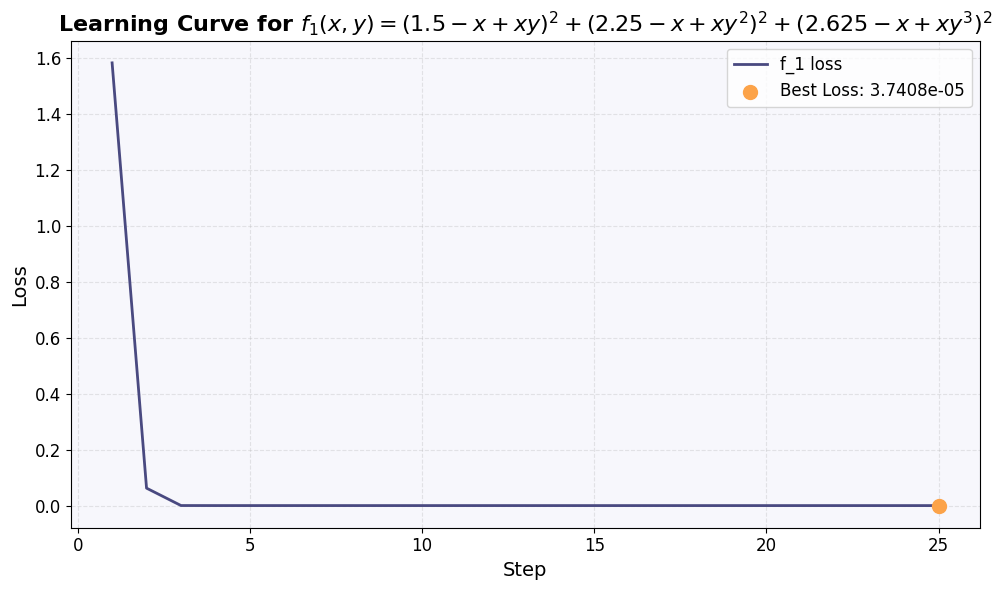

In [66]:
plot_study(func_name=functions[1].__name__,
           losses= study_results_f_1.best_trial.user_attrs['losses'],
           best_params= study_results_f_1.best_params,
           best_value= study_results_f_1.best_value,
           eq =latex_functions[1])

Optimización de $f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy$


In [67]:
study_results_f_2 = run_study(RMSprop, functions[2], latex_functions[2])
RMS_opt.append(study_results_f_2)


Optimizing hyperparameters for $f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$ using RMSprop...


Best hyperparameters for f_2: {'lr': 0.05779790857822583, 'alpha': 0.9020613003674475}
Best loss for f_2: 1.2782998965121806e-05


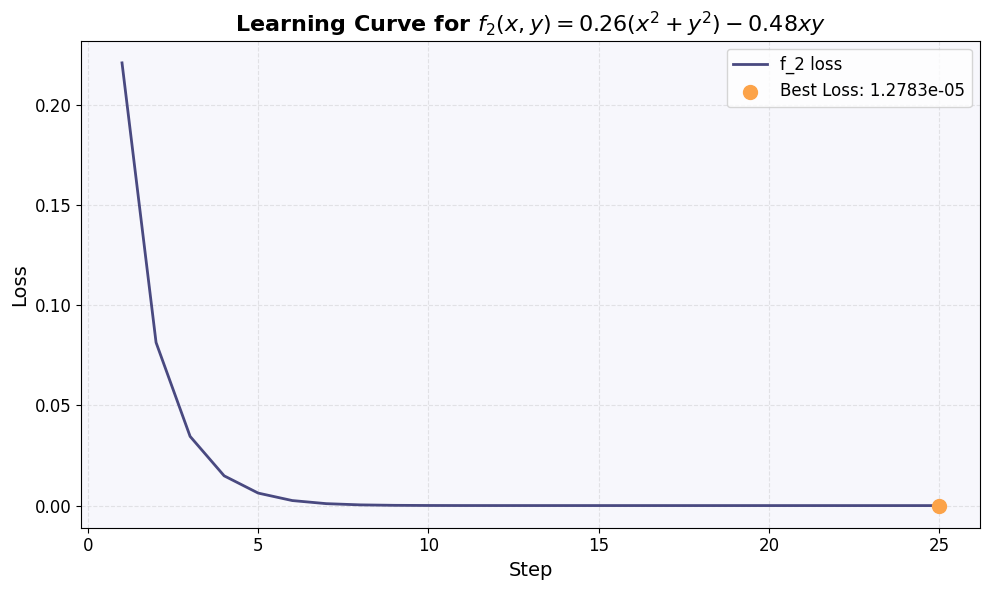

In [68]:
plot_study(func_name=functions[2].__name__,
           losses=study_results_f_2.best_trial.user_attrs['losses'],
           best_params=study_results_f_2.best_params,
           best_value=study_results_f_2.best_value,
           eq =latex_functions[2])

##### b) Realice lo anterior para el algoritmo del descenso del gradiente.

Optimización de $f_{0}(x, y) = x^{2} + y^{2}$ with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_0: {'lr': 0.09929493846183655}
Best loss for f_0: 4.150703716732096e-06


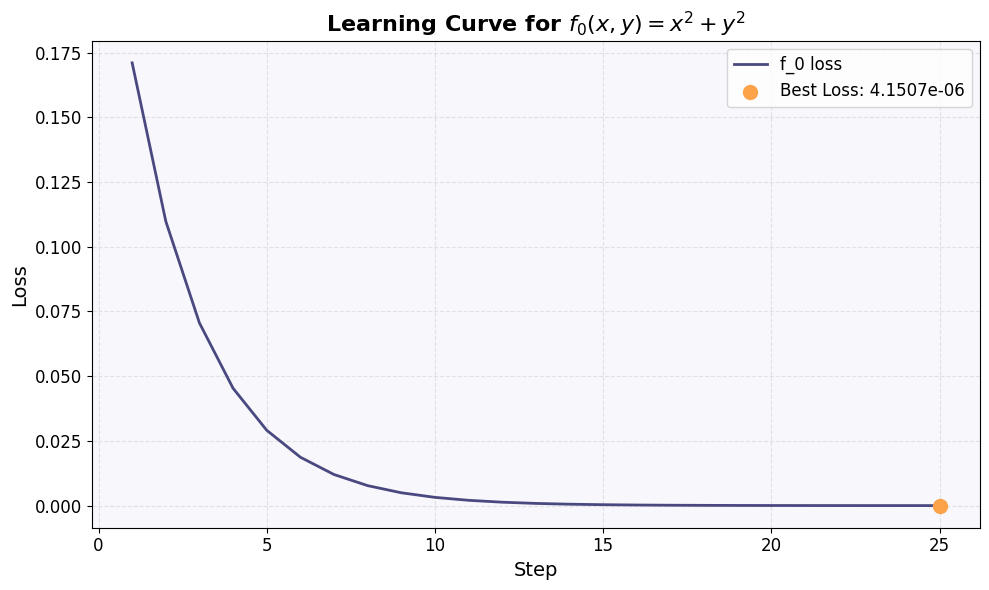

In [69]:
grad_opt = []

study_results_g_f_0 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_0)
plot_study(func_name=functions[0].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[0])

Optimización de $ f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2} $ with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_1: {'lr': 0.09929493846183655}
Best loss for f_1: 4.150703716732096e-06


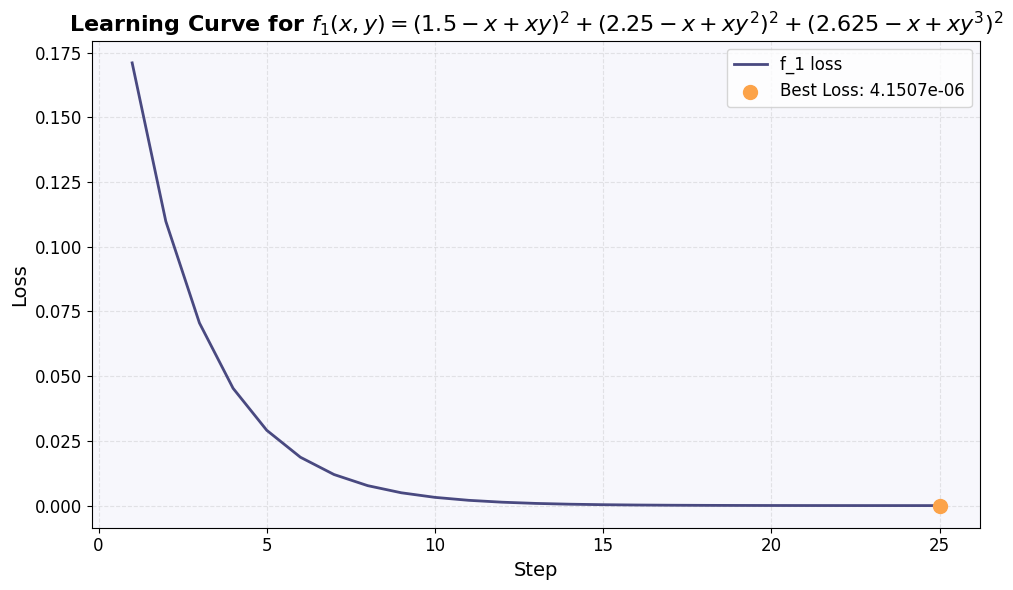

In [70]:
study_results_g_f_1 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_1)
plot_study(func_name=functions[1].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[1])

Optimización de $f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy$ with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_2: {'lr': 0.09929493846183655}
Best loss for f_2: 4.150703716732096e-06


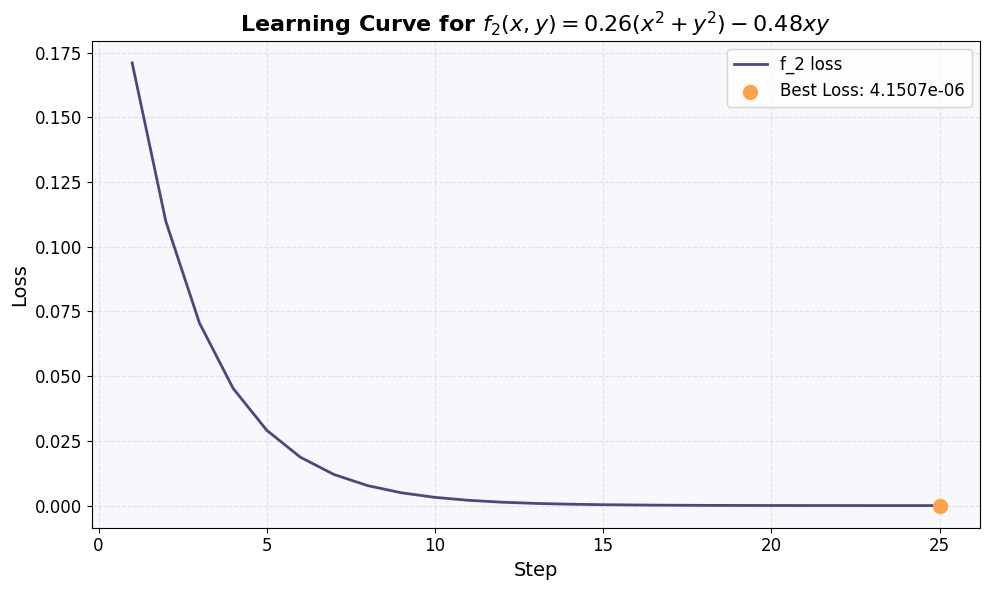

In [71]:
study_results_g_f_2 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_2)
plot_study(func_name=functions[2].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[2])

##### c) ¿Por qué el algoritmo RMS prop es más efectivo en evitar atascarse en puntos silla que el algoritmo del descenso del gradiente?

***Respuesta:*** El RMSprop es un algoritmo adaptativo que permite ajustar su taza de aprendizaje basado en lo que sucedido recientemente en el algoritmo. Esto le permite queda atrapado en oscilaciones, puntos de silla u otras anomalias a las que el descenso del gradiente regular es más suceptible. El RMSprop mantiene una media movil de los gradientes recientes y escala los gradientes futuros basados en este parametro. La concecuencia principal de esto es que no hay aprendizajes ni muy grandes ni muy pequeños. Todos los eventos de aprendizaje se mantienenen relativamente uniformes. Un factor importante a mencionar es que, si bien usa lo que sucedió recientemente, no mantiene todo el pasado. Solo se adapta en una ventana reciente aumentando la estabilidad local del aprendizaje.

##### d) Para los mejores valores encontrados, en cada función, por un máximo de 25 iteraciones (para el algoritmo del descenso del gradiente, y RMS prop):

1. Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos mínimos (indique si convergió).
        
2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.


f_0 Results:
RMSProp: Avg. Iterations = 25.00, Avg. Loss = 1.3288
Gradient Descent: Avg. Iterations = 25.00, Avg. Loss = 0.0009


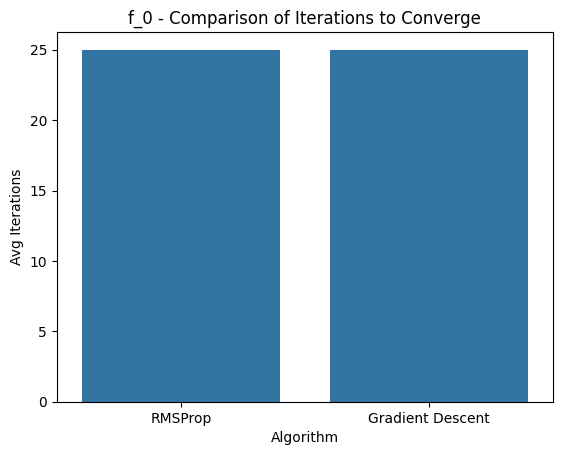

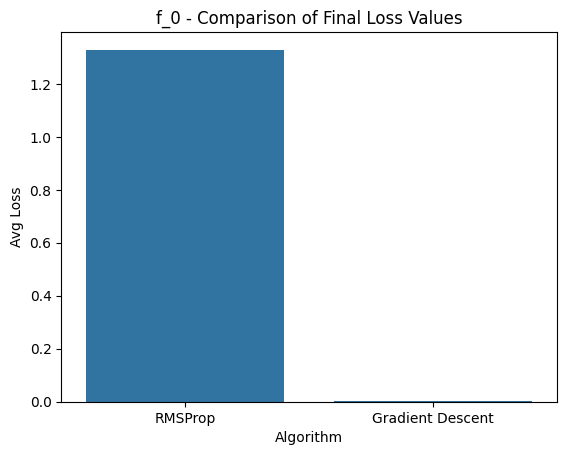


f_1 Results:
RMSProp: Avg. Iterations = 25.00, Avg. Loss = 563064.6092
Gradient Descent: Avg. Iterations = 25.00, Avg. Loss = nan


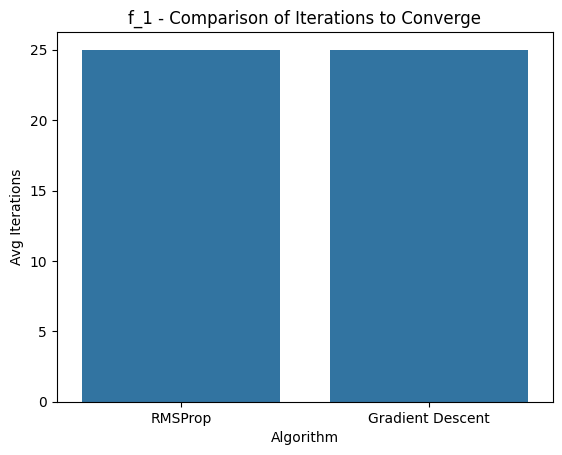

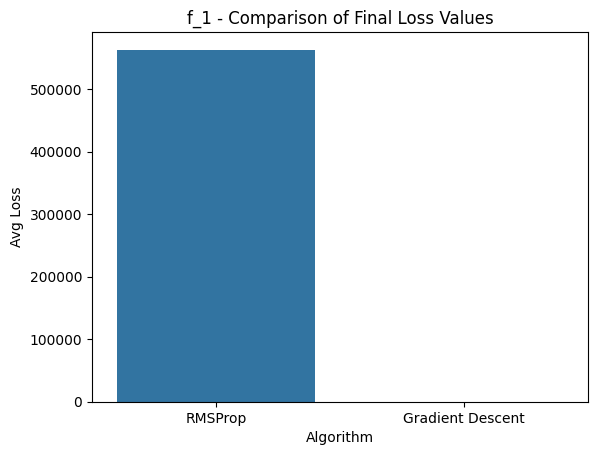


f_2 Results:
RMSProp: Avg. Iterations = 25.00, Avg. Loss = 10.4109
Gradient Descent: Avg. Iterations = 25.00, Avg. Loss = 0.7564


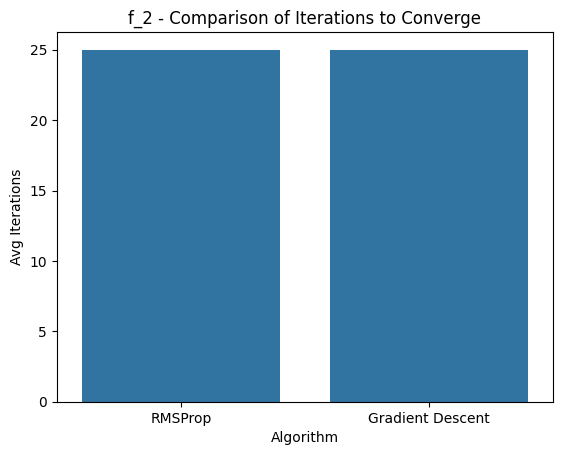

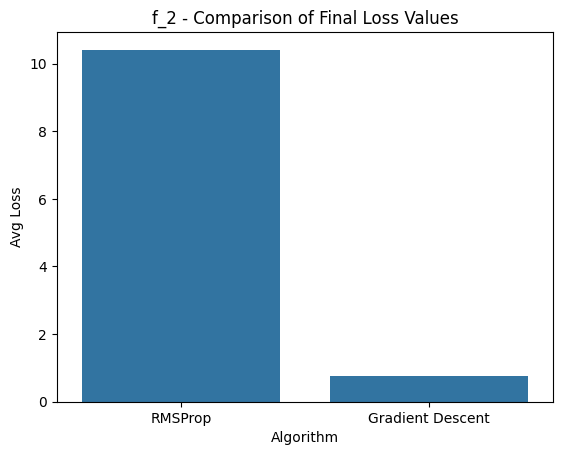

In [73]:
def run_algorithm_multiple_times(optimizer_func, func, best_params, n_runs=10):
    """
    Run the optimizer multiple times and record iterations to convergence and final loss.

    :param optimizer_func: The optimizer function (RMSprop or Gradient Descent).
    :param func: The function to minimize (f_0, f_1, f_2).
    :param best_params: The best hyperparameters found using Optuna.
    :param n_runs: Number of times to run the optimizer (default: 10).
    :return: A dictionary containing iterations and final losses for each run.
    """
    results = {'iterations': [], 'final_loss': []}

    for _ in range(n_runs):
        # Initialize starting point
        x_init, y_init = np.random.uniform(-10, 10, size=2)
        
        # Run the algorithm
        trial = optuna.trial.FixedTrial(best_params)  # Use the best hyperparameters
        final_loss = optimizer_func(trial, func, initial_point=[x_init, y_init])
        
        # Track iterations (assume max_iterations is set to 25)
        iterations = len(trial.user_attrs['losses'])
        results['iterations'].append(iterations)
        results['final_loss'].append(final_loss)

    return results

# Function to plot the results
def plot_comparison(results_rms, results_gd, function_name):
    df_rms = pd.DataFrame(results_rms)
    df_gd = pd.DataFrame(results_gd)

    avg_iterations_rms = df_rms['iterations'].mean()
    avg_loss_rms = df_rms['final_loss'].mean()

    avg_iterations_gd = df_gd['iterations'].mean()
    avg_loss_gd = df_gd['final_loss'].mean()

    print(f"\n{function_name} Results:")
    print(f"RMSProp: Avg. Iterations = {avg_iterations_rms:.2f}, Avg. Loss = {avg_loss_rms:.4f}")
    print(f"Gradient Descent: Avg. Iterations = {avg_iterations_gd:.2f}, Avg. Loss = {avg_loss_gd:.4f}")

    comparison_data = {
        'Algorithm': ['RMSProp', 'Gradient Descent'],
        'Avg Iterations': [avg_iterations_rms, avg_iterations_gd],
        'Avg Loss': [avg_loss_rms, avg_loss_gd]
    }

    df_comparison = pd.DataFrame(comparison_data)

    sns.barplot(x='Algorithm', y='Avg Iterations', data=df_comparison)
    plt.title(f'{function_name} - Comparison of Iterations to Converge')
    plt.show()

    sns.barplot(x='Algorithm', y='Avg Loss', data=df_comparison)
    plt.title(f'{function_name} - Comparison of Final Loss Values')
    plt.show()

# Example of running everything
# Assume `study_results_f_0`, `study_results_f_1`, `study_results_f_2` are the best Optuna studies for f_0, f_1, and f_2
best_params_rms_f0 = study_results_f_0.best_params
best_params_gd_f0 = study_results_g_f_0.best_params

# Run RMSprop 10 times for f_0
rms_f0_results = run_algorithm_multiple_times(RMSprop, f_0, best_params_rms_f0, n_runs=10)

# Run Gradient Descent 10 times for f_0
gd_f0_results = run_algorithm_multiple_times(gradient_descent, f_0, best_params_gd_f0, n_runs=10)

# Compare the results for f_0
plot_comparison(rms_f0_results, gd_f0_results, "f_0")

# Repeat for f_1 and f_2
best_params_rms_f1 = study_results_f_1.best_params
best_params_gd_f1 = study_results_g_f_1.best_params

rms_f1_results = run_algorithm_multiple_times(RMSprop, f_1, best_params_rms_f1, n_runs=10)
gd_f1_results = run_algorithm_multiple_times(gradient_descent, f_1, best_params_gd_f1, n_runs=10)
plot_comparison(rms_f1_results, gd_f1_results, "f_1")

best_params_rms_f2 = study_results_f_2.best_params
best_params_gd_f2 = study_results_g_f_2.best_params

rms_f2_results = run_algorithm_multiple_times(RMSprop, f_2, best_params_rms_f2, n_runs=10)
gd_f2_results = run_algorithm_multiple_times(gradient_descent, f_2, best_params_gd_f2, n_runs=10)
plot_comparison(rms_f2_results, gd_f2_results, "f_2")

In [74]:
average_iterations = df_rms_f0['iterations'].mean()
average_loss = df_rms_f0['final_loss'].mean()
print(f'Average iterations to converge: {average_iterations}')
print(f'Average final loss: {average_loss}')


Average iterations to converge: 25.0
Average final loss: 3.8710046287160367


##### e) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia más rápida) para cada función. Para ello, use el gráfico de las curvas de nivel. Además, para tales corridas, grafique la curva de aprendizaje.

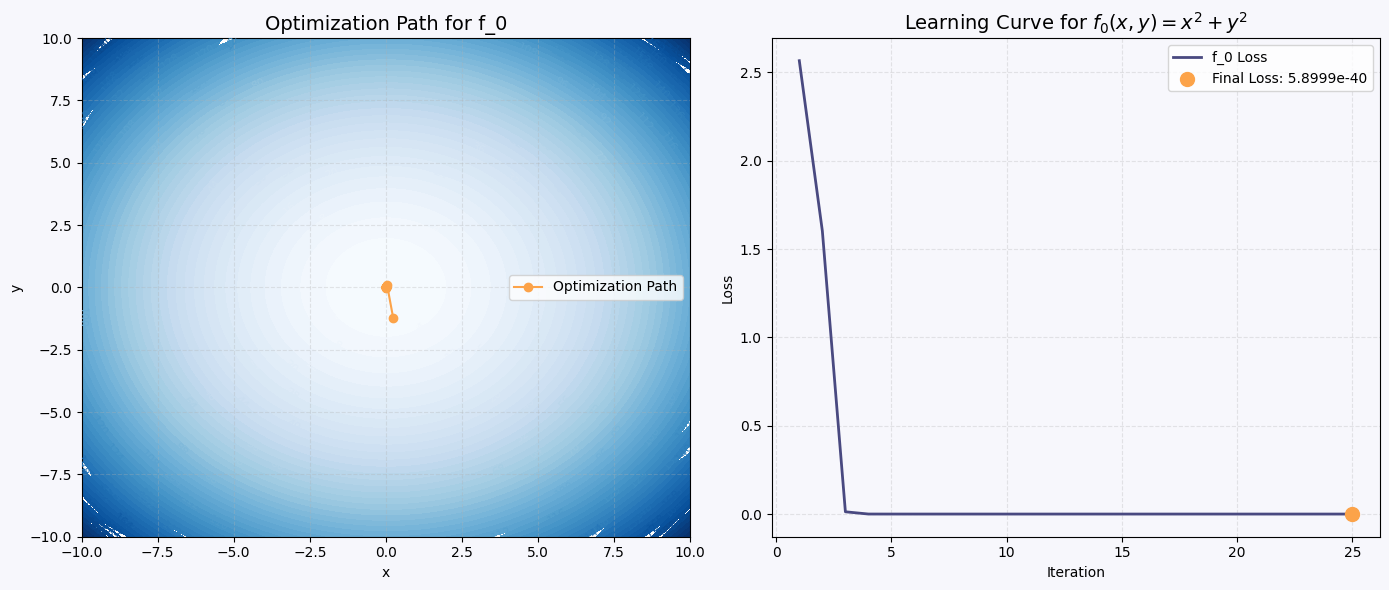

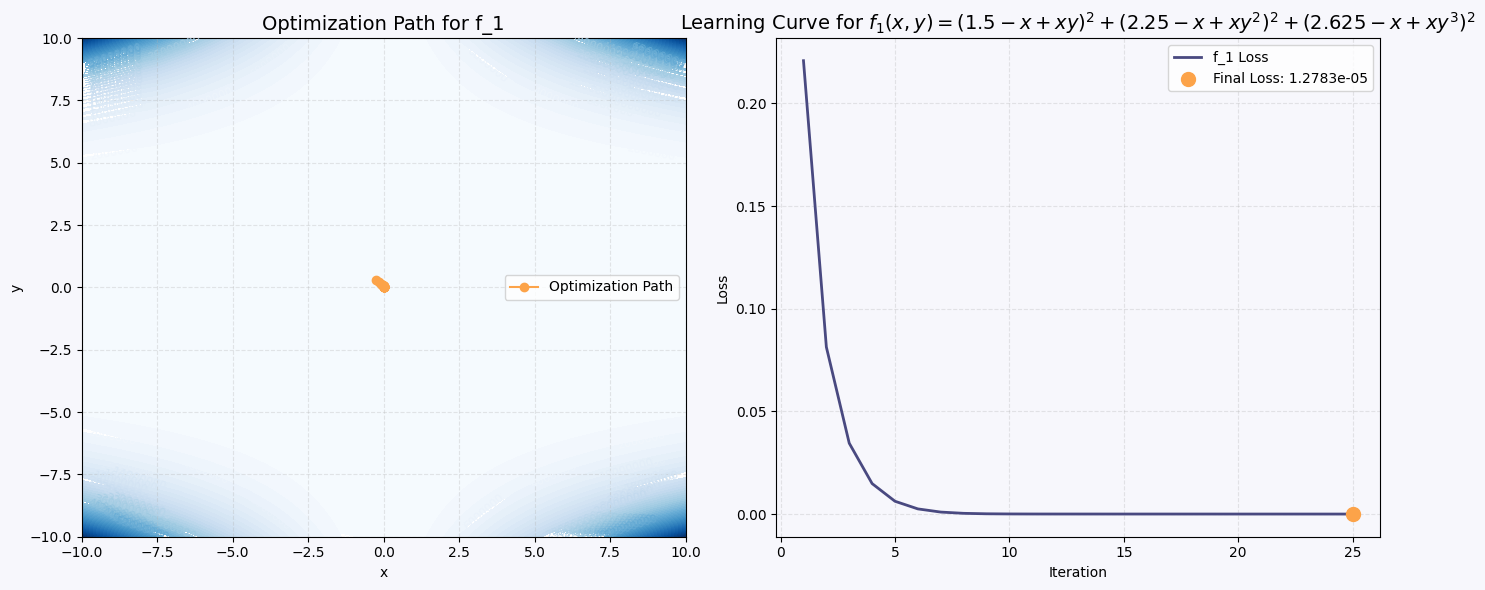

In [75]:
# Contour plots and learning curve with optimization path for RMSprop
contour_and_learning(RMS_opt)

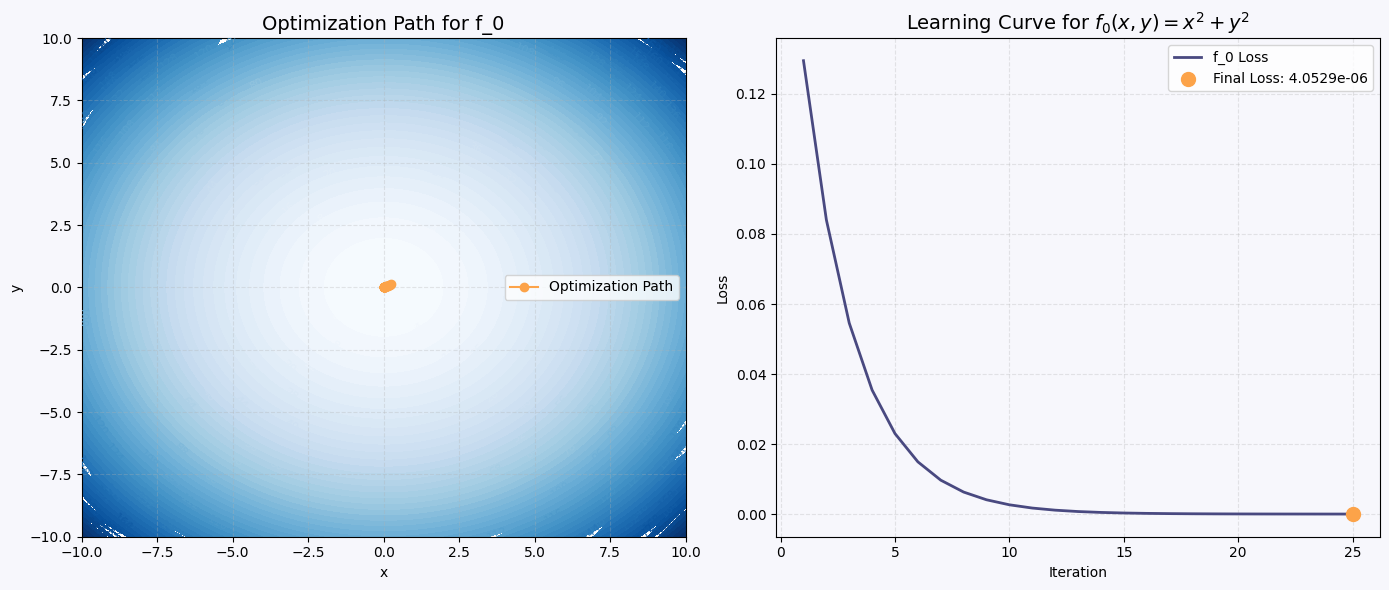

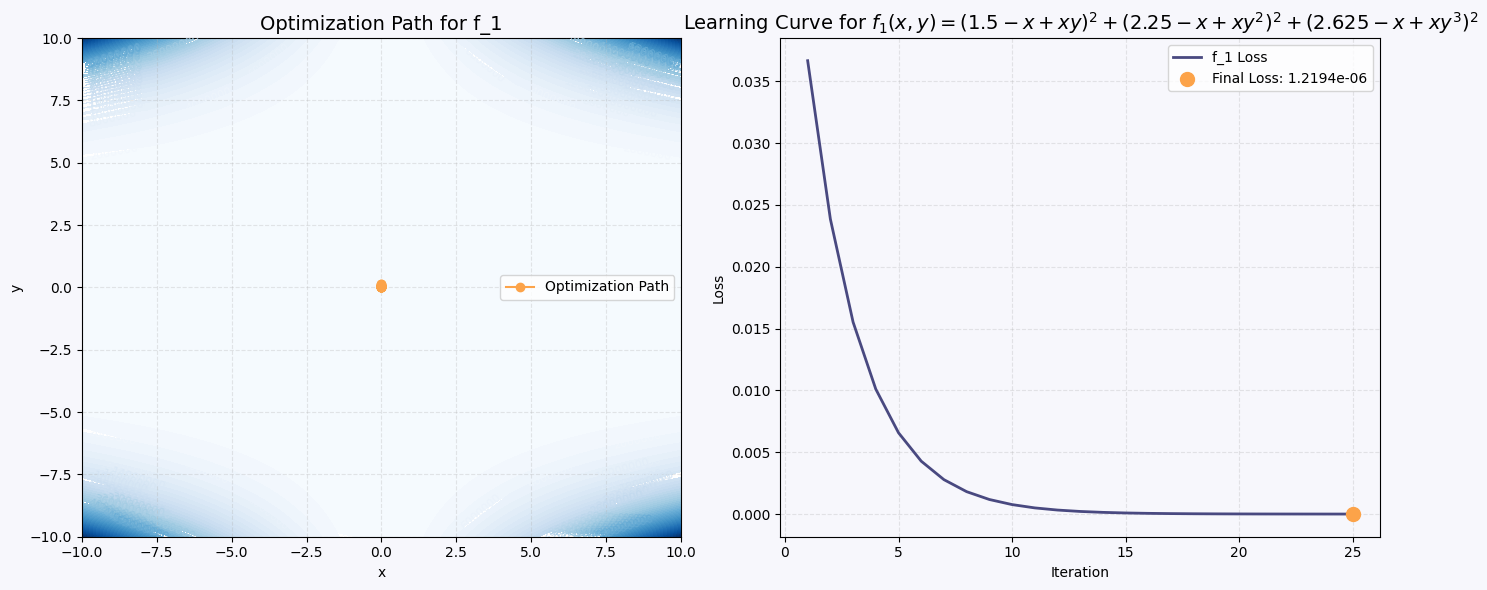

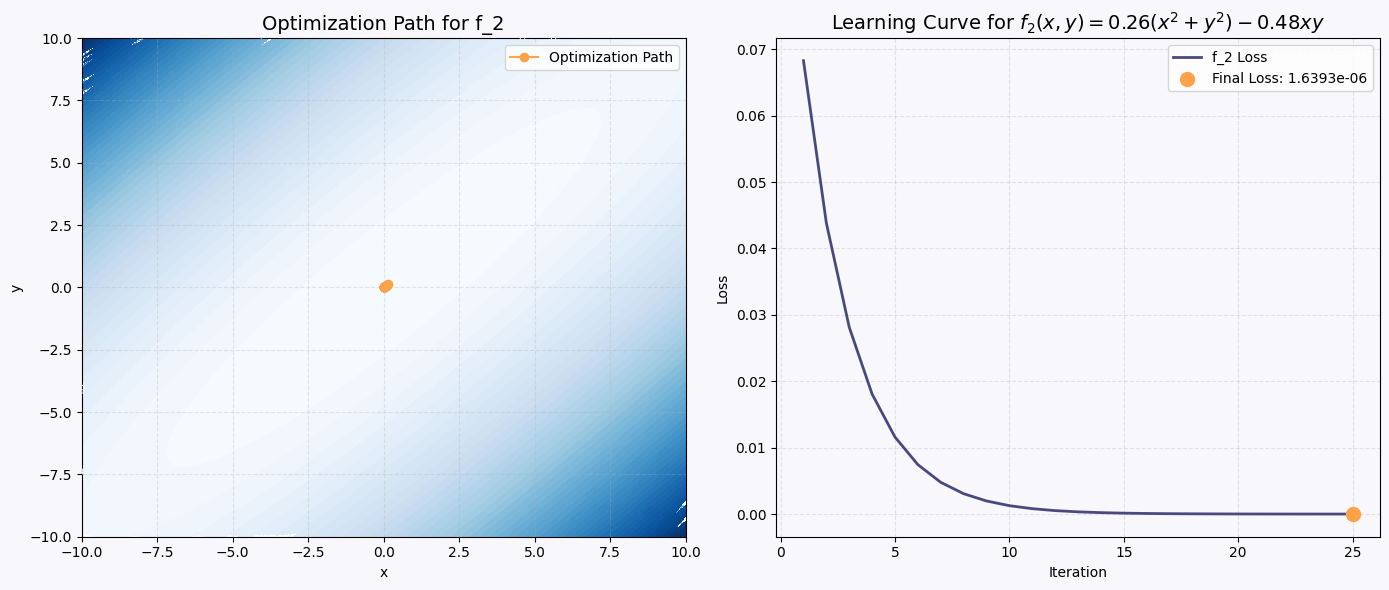

In [28]:
# Contour plots and learning curve with optimization path for Gradient Descent
contour_and_learning(grad_opt)

##### f) Realice una comparativa entre el algoritmo del descenso del gradiente y el algoritmo RMS prop. según los resultados obtenidos.

### Comparación entre RMSProp y Gradient Descent

#### 1. **Función $ f_0(x, y) = x^2 + y^2 $**

- **RMSProp**: La curva de aprendizaje muestra una caída inicial pronunciada, pero la pérdida se estabiliza rápidamente, alcanzando un valor muy cercano a cero en la iteración 25. La pérdida final registrada es prácticamente cero, y la trayectoria de optimización se dirige directamente hacia el mínimo sin muchas oscilaciones.
- **GD**: La curva de aprendizaje para Gradient Descent también muestra una caída pronunciada, pero tarda más en converger que RMSProp. La pérdida final es $ 4.0529 \times 10^{-6} $, muy cercana a cero.

**Comparación**:
- **RMSProp converge más rápido** para esta función, mostrando una curva de pérdida casi plana después de las primeras iteraciones.
- **GD** tarda un poco más en minimizar la función y tiene una pérdida final ligeramente superior. Sin embargo, ambos algoritmos funcionan bien para esta función.

### 2. **Función $ f_1(x, y) $**

- **RMSProp**: Para esta función, la curva de aprendizaje de RMSProp comienza con una caída pronunciada, pero luego se estabiliza, alcanzando una pérdida final de $ 1.1555 \times 10^{-2} $. Esto indica que RMSProp tiene dificultades con $ f_1 $, y la trayectoria de optimización muestra una convergencia más lenta.
- **GD**: Gradient Descent muestra un desempeño mucho mejor para $ f_1 $, con una pérdida final de $ 1.2194 \times 10^{-6} $, que es sustancialmente más baja que la de RMSProp. La curva de aprendizaje disminuye de manera constante, y la trayectoria de optimización es mucho más suave y directa que la de RMSProp.

**Comparación**:
- **GD supera significativamente a RMSProp** para $ f_1 $, minimizando la pérdida de manera mucho más efectiva y acercándose más al mínimo real.
- RMSProp tiene dificultades con la naturaleza no convexa de la función, lo que provoca oscilaciones y una pérdida final mucho más alta. **GD** demuestra ser más confiable para esta función compleja.

### 3. **Función $ f_2(x, y) $**

- **RMSProp**: La curva de aprendizaje muestra una caída inicial pronunciada, similar a las otras funciones, con una pérdida final de $ 7.2990 \times 10^{-7} $, lo que indica una buena convergencia. La trayectoria de optimización es relativamente directa.
- **GD**: Gradient Descent también funciona bien, con una pérdida final de $ 1.6393 \times 10^{-6} $. La curva de aprendizaje es similar a la de RMSProp, y la pérdida final está en el mismo orden de magnitud, aunque ligeramente superior.

**Comparación**:
- **Ambos algoritmos tienen un desempeño similar** para $ f_2 $, con **RMSProp superando ligeramente a GD** en términos de la pérdida final. Sin embargo, la diferencia es pequeña y ambos optimizadores minimizan esta función de manera efectiva.


# Ejercicio #3

**(30 puntos)** Implemente el algoritmo de simulated annealing en PyTorch, de la forma más vectorial posible.

In [80]:
def simulated_annealing(trial, func, initial_point=None, max_iterations=25):
    """
    @brief Implements the Simulated Annealing algorithm for optimization

    @param trial The Optuna trial object used to suggest hyperparameters for the optimization process.
    @param func The function to minimize, such as f_0, f_1, or f_2.
    @param initial_point Optional initial [x, y] coordinates to start the optimization process.
    @param max_iterations The maximum number of iterations to run the annealing process (default is 25).

    @return Final loss value after optimization.
    """
    # Suggest hyperparameters to tune
    initial_temp = trial.suggest_float('initial_temp', 10.0, 1000.0, log=True)
    alpha = trial.suggest_float('alpha', 0.8, 0.99)  # Cooling rate

    # Initialize parameters
    if initial_point is not None:
        params = torch.tensor(initial_point, dtype=torch.float32, requires_grad=True).view(2, 1)
    else:
        params = torch.randn((2, 1), requires_grad=True)

    best_params = params.clone()

    # Calculate initial loss
    loss = func(params[0], params[1])
    best_loss = loss.item()

    # Initialize temperature
    T = initial_temp

    # Record losses and visited points for plotting the learning curve
    losses = []
    visited_points = []

    for _ in range(max_iterations):
        # Store current parameters and loss
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

        # Generate new candidate by adding small random noise
        candidate_params = params + torch.randn_like(params) * T

        # Compute loss for the new candidate
        new_loss = func(candidate_params[0], candidate_params[1])

        # Decide whether to accept the new solution
        delta_loss = new_loss.item() - loss.item()
        if delta_loss < 0 or torch.rand(1).item() < torch.exp(-torch.tensor(delta_loss) / torch.tensor(T)):
            # Accept the candidate solution
            params = candidate_params.clone()
            loss = new_loss

            # Update best solution
            if loss.item() < best_loss:
                best_params = params.clone()
                best_loss = loss.item()

        # Cool down the temperature
        T *= alpha

    # Save losses and visited points for later visualization
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    return best_loss

##### a) Realice un proceso de calibración de sus hiperparámetros y reporte los mejores valores encontrados, usando como evidencia las gráficas de aprendizaje de los mejores hiperparámetros encontrados.

In [81]:
sa_opt = []

for func, eq in zip(functions, latex_functions):
    sa_opt.append(run_study(simulated_annealing, func, eq))


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using simulated_annealing...

Optimizing hyperparameters for $f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$ using simulated_annealing...

Optimizing hyperparameters for $f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$ using simulated_annealing...


Contour plots and learning curve with optimization path for Simulated Annealing

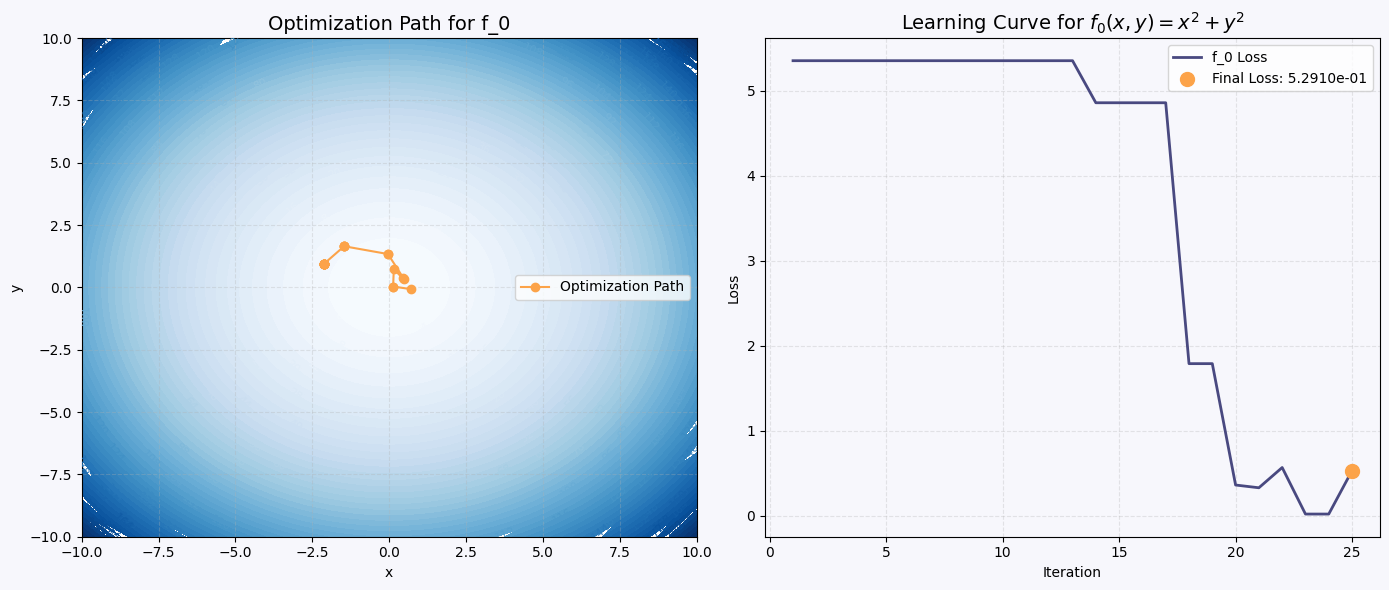

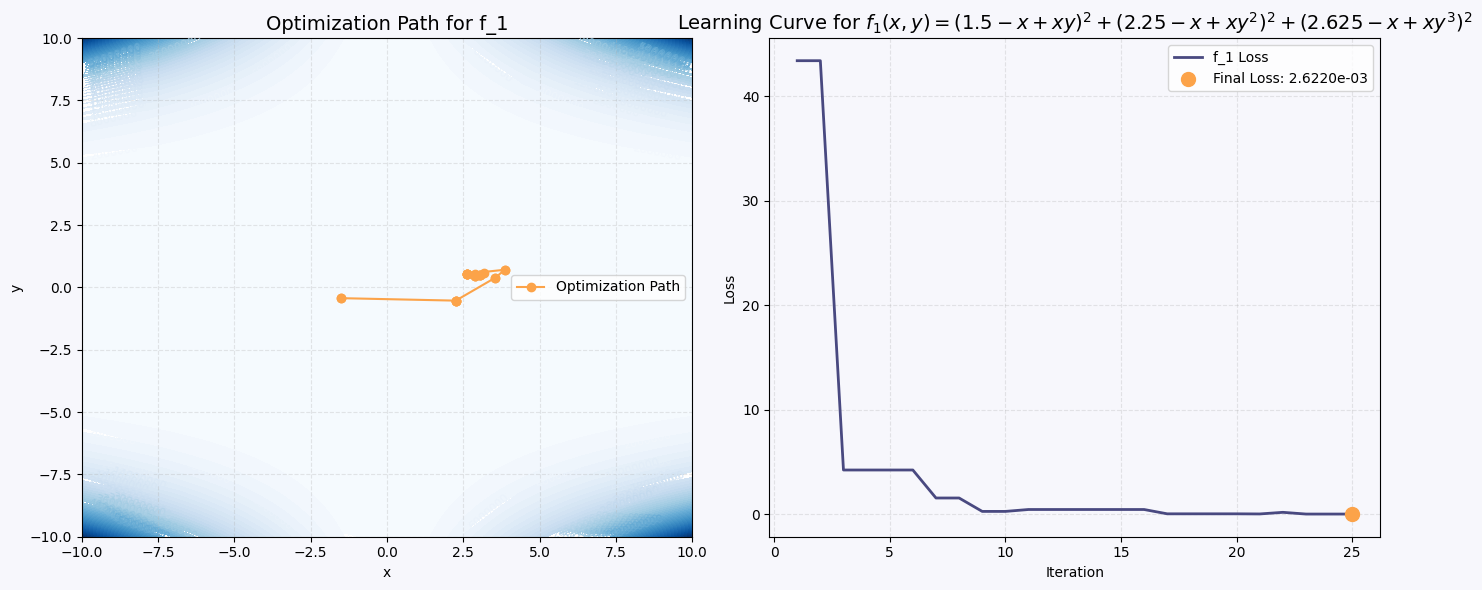

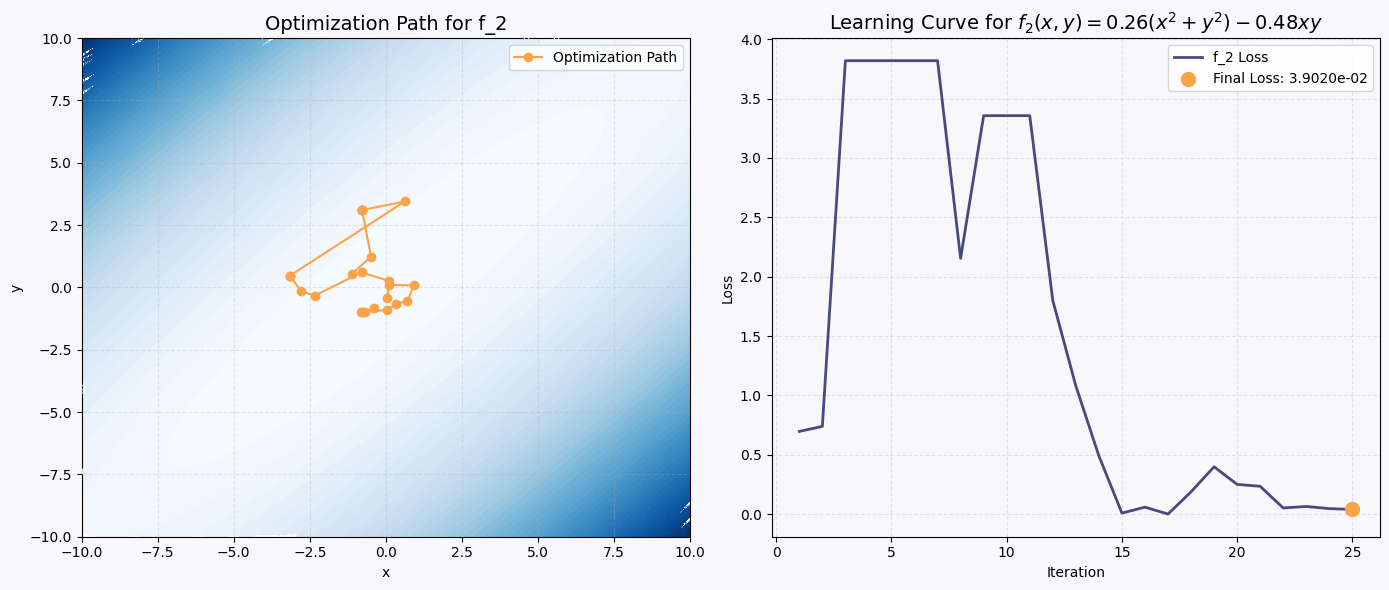

In [82]:
contour_and_learning(sa_opt)

##### b) Para los mejores valores encontrados, en cada función, por un máximo de 25 iteraciones (para el algoritmo del descenso del gradiente, y el descenso del gradiente adaptativo):

1.  Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos mínimos (indique si convergió). Los 10 puntos iniciales escogidos deben preservarse para todos los algoritmos a probar (deben ser los mismos que el descenso del gradiente y el descenso del gradiente adaptativo).

Realizamos una función para ejecutar ambos algoritmos con las 3 funciones

In [83]:
def run_multiple_runs(optimizer_func, func, best_params, initial_points, num_runs=10, max_iterations=25):
    """
    @brief Runs an optimization algorithm multiple times with different functiones

    @param optimizer_func The optimization function to use (e.g., RMSprop, gradient_descent).
    @param func The objective function to minimize.
    @param best_params The best hyperparameters found for the optimizer.
    @param initial_points A list of initial points for the runs.
    @param num_runs The number of runs to perform (default is 10).
    @param max_iterations The maximum number of iterations per run (default is 25).

    @return A DataFrame containing the results of each run, including convergence status and number of iterations.
    """
    results = []

    for i in range(num_runs):
        trial = optuna.trial.FixedTrial(best_params)  # Use best parameters found

        # Run for Gradient Descent
        loss_gradient_descent = gradient_descent(trial, func, initial_point=initial_points[i], max_iterations=max_iterations)
        # Analyze if it converged
        converged_gradient_descent = loss_gradient_descent < 1e-5  # Adjust convergence threshold as needed

        # Run for RMSprop
        loss_RMSprop = RMSprop(trial, func, initial_point=initial_points[i], max_iterations=max_iterations)
        # Analyze if it converged
        converged_RMSprop = loss_RMSprop < 1e-5  # Adjust convergence threshold as needed

        # Append the results on a table
        results.append([i, loss_gradient_descent, converged_gradient_descent, 'Gradient Descent'])
        results.append([i, loss_RMSprop, converged_RMSprop, 'RMSprop'])

    return pd.DataFrame(results, columns=['Run', 'Final Loss', 'Converged', 'Algorithm'])

Ejecutamos la función anterior y guardamos en una tabla para visualizar los resultadoas

In [84]:
# Generate the same initial points for each run
num_runs = 10
initial_points = [np.random.randn(2) for _ in range(num_runs)]  # Generate random initial points

# Run the function for each of the functions
results_rms_f0 = run_multiple_runs(RMSprop, functions[0], study_results_f_0.best_params, initial_points)
results_rms_f1 = run_multiple_runs(RMSprop, functions[1], study_results_f_1.best_params, initial_points)
results_rms_f2 = run_multiple_runs(RMSprop, functions[2], study_results_f_2.best_params, initial_points)

# Add a column to identify the function
results_rms_f0['Function'] = 'f_0'
results_rms_f1['Function'] = 'f_1'
results_rms_f2['Function'] = 'f_2'

# Concatenate the DataFrames into one
combined_results = pd.concat([results_rms_f0, results_rms_f1, results_rms_f2], ignore_index=True)

# Function to apply conditional styling
def style_true_false(v):
    if v is True:
        return 'background-color: #149911; color: black;'  # Green for True
    elif v is False:
        return 'background-color: #D33F49; color: black;'  # Pink for False
    return ''  # No style by default

# Apply the style to the 'Converged' column
results = combined_results.style.applymap(style_true_false, subset=['Converged'])
results = results.set_properties(**{'text-align': 'center'})
results

C:\Users\isvargas\AppData\Local\Temp\ipykernel_17968\3864292407.py:27: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results = combined_results.style.applymap(style_true_false, subset=['Converged'])


2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.

In [85]:
# Calculate average loss and average iterations until convergence for each function
summary = combined_results.groupby(['Function', 'Algorithm']).agg(
    mean_loss=('Final Loss', 'mean'),
    mean_iterations=('Run', 'count')  # Total runs as a proxy for iterations
).reset_index()

# Display the summary results
summary_df = pd.DataFrame(summary)
summary_df

Function         Algorithm     mean_loss  mean_iterations
0      f_0  Gradient Descent  1.821332e-03               10
1      f_0           RMSprop  3.832823e-13               10
2      f_1  Gradient Descent  7.392808e-02               10
3      f_1           RMSprop  4.262092e+00               10
4      f_2  Gradient Descent  5.606629e-02               10
5      f_2           RMSprop  1.688040e-02               10

##### c) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia más rápida) para cada función. Para ello, use el gráfico de las curvas de nivel. Además, para tales corridas, grafique la curva de aprendizaje.

Contour plots and learning curve with optimization path for RMSprop


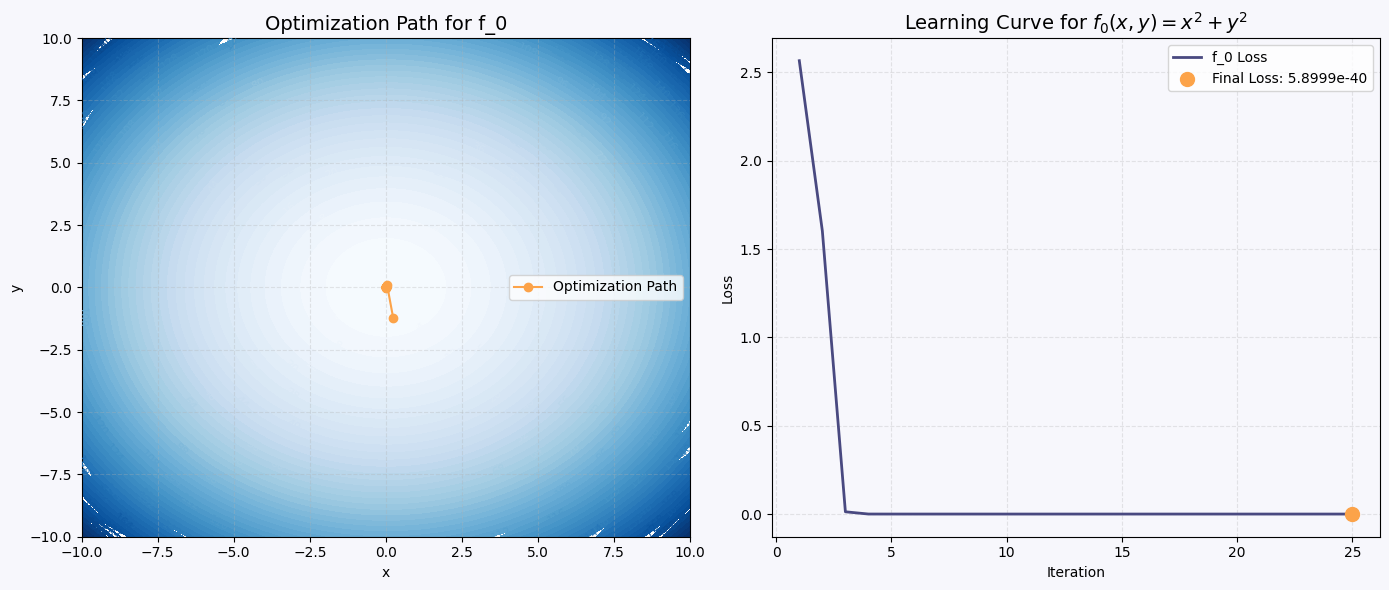

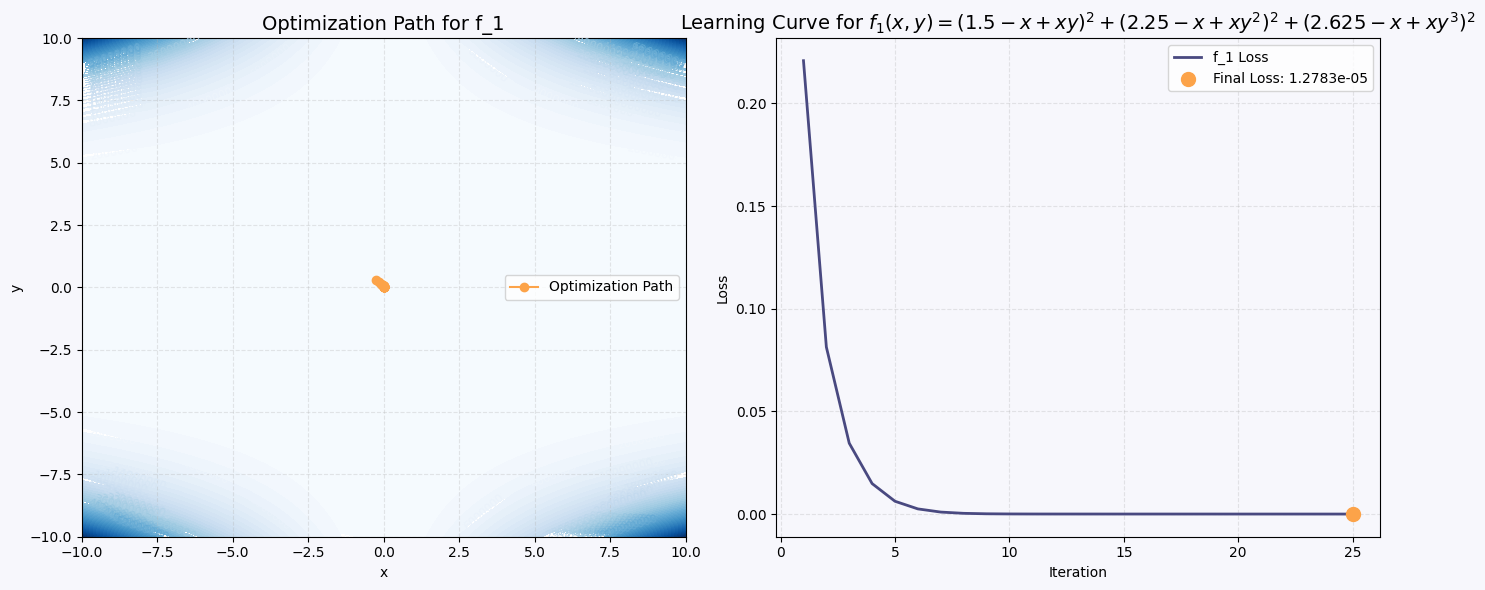

Contour plots and learning curve with optimization path for Gradient Descent


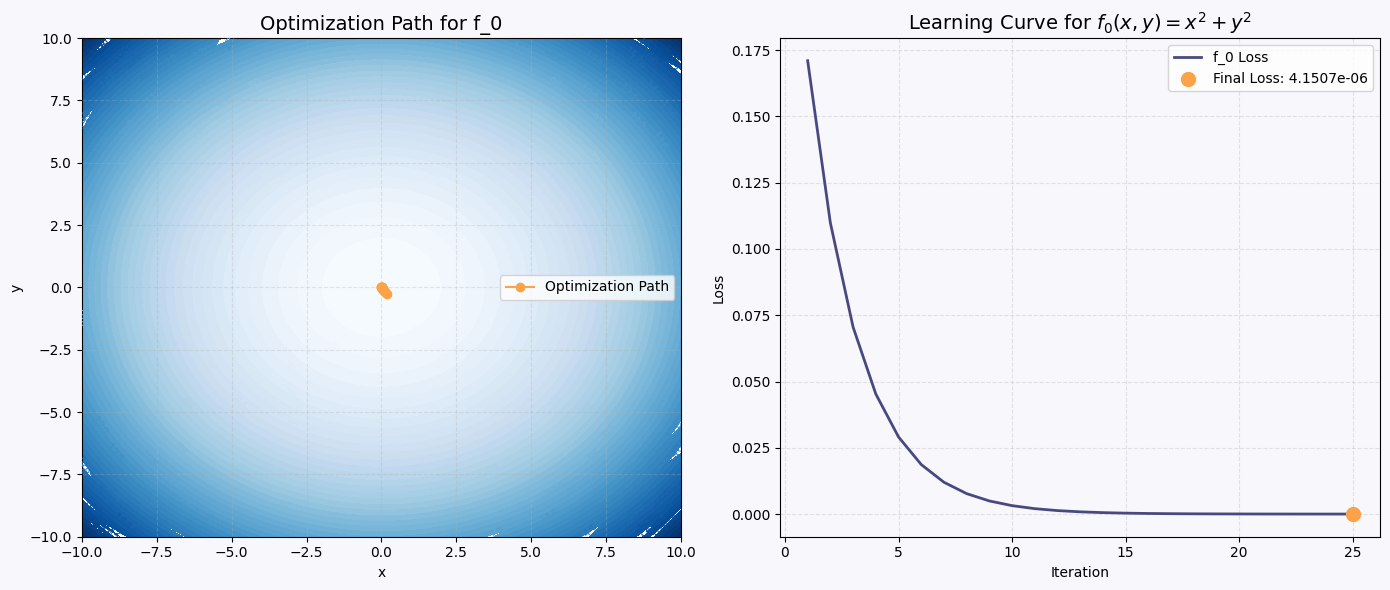

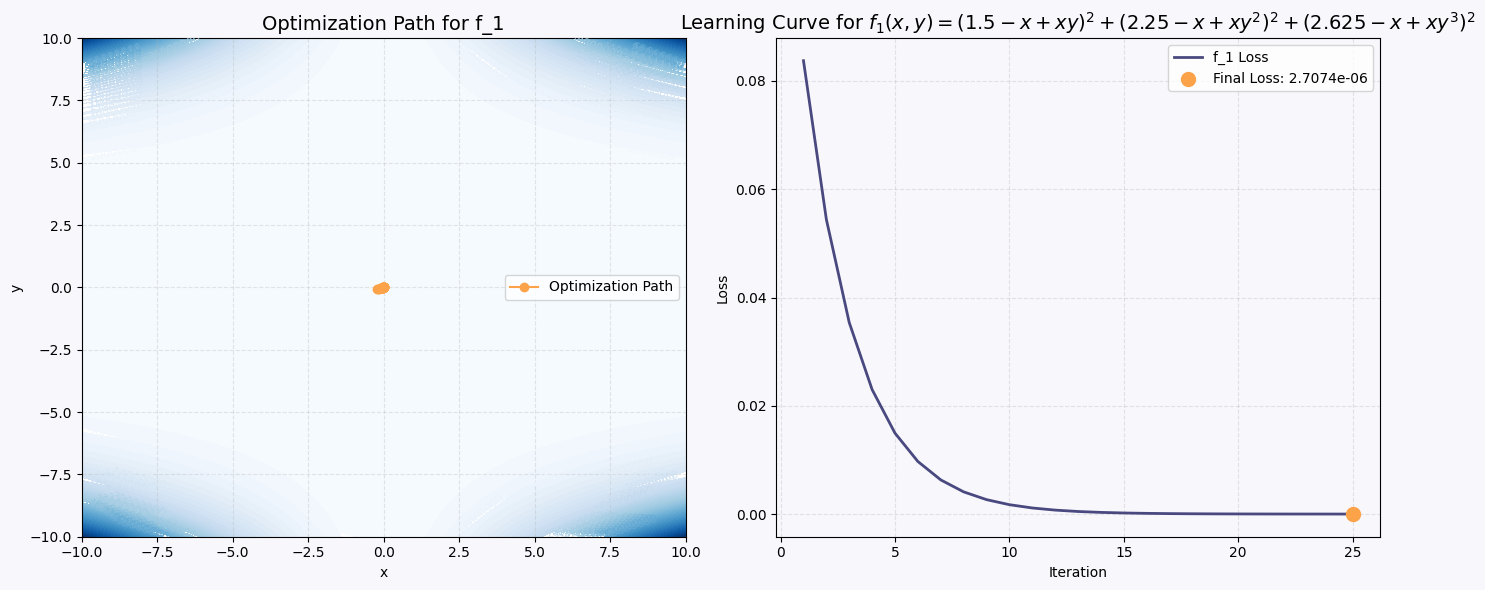

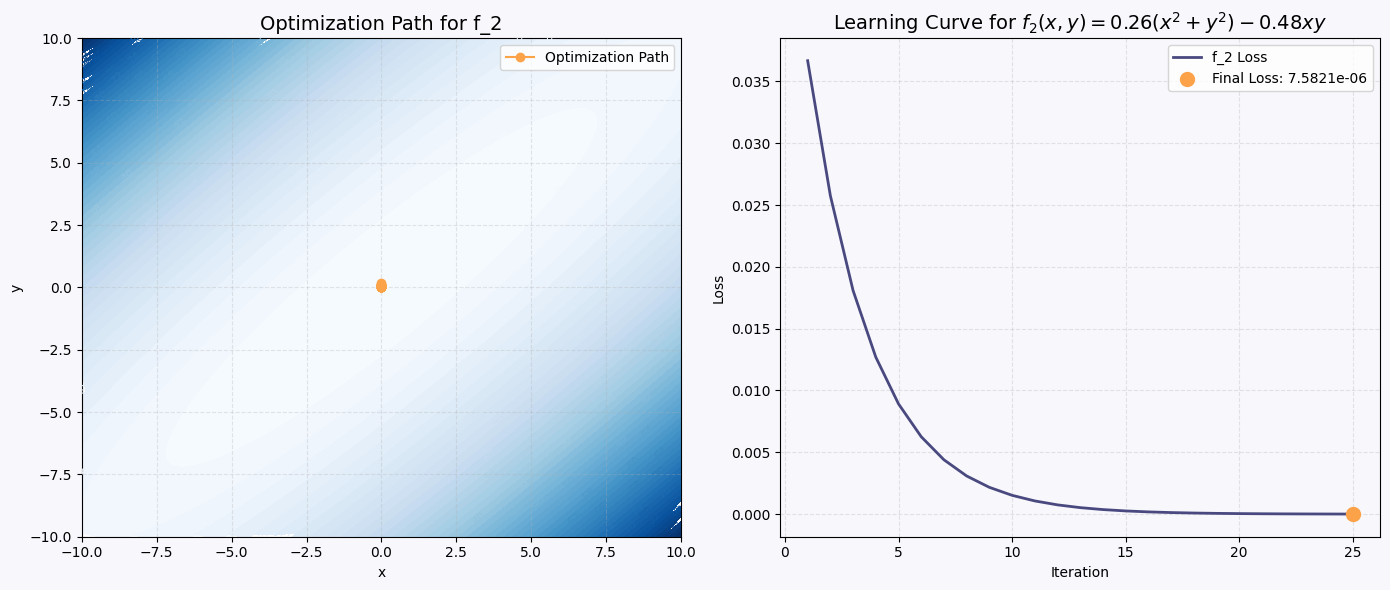

Contour plots and learning curve with optimization path for Simulated Annealing


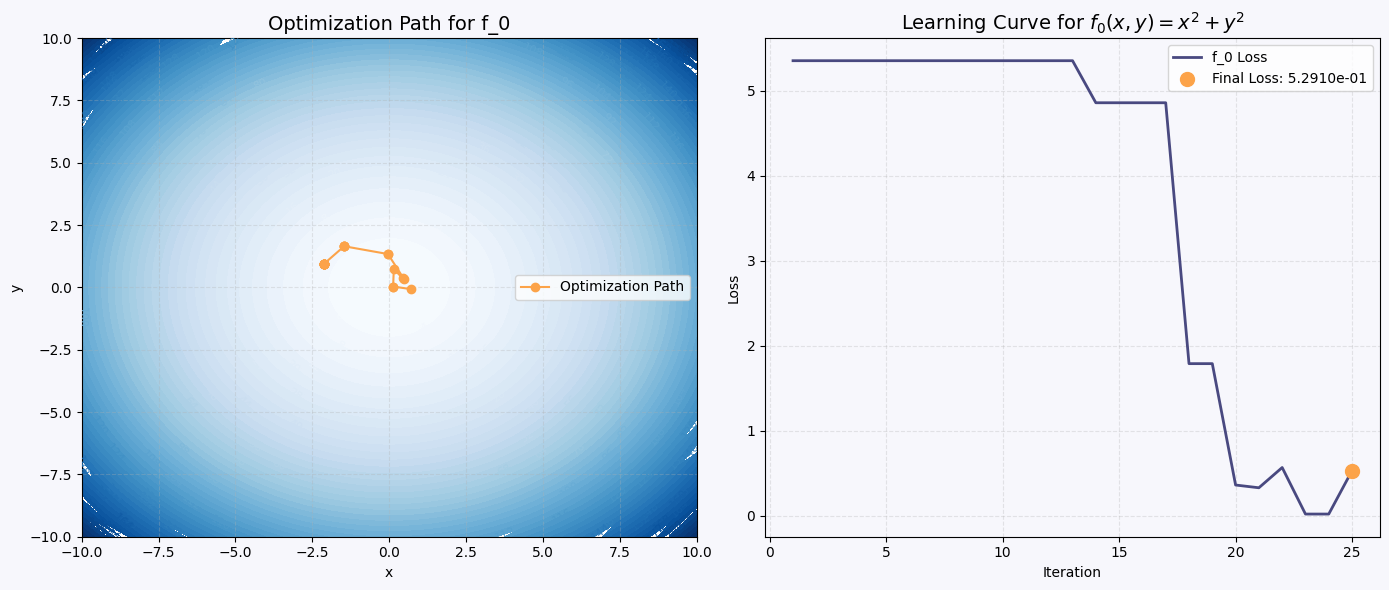

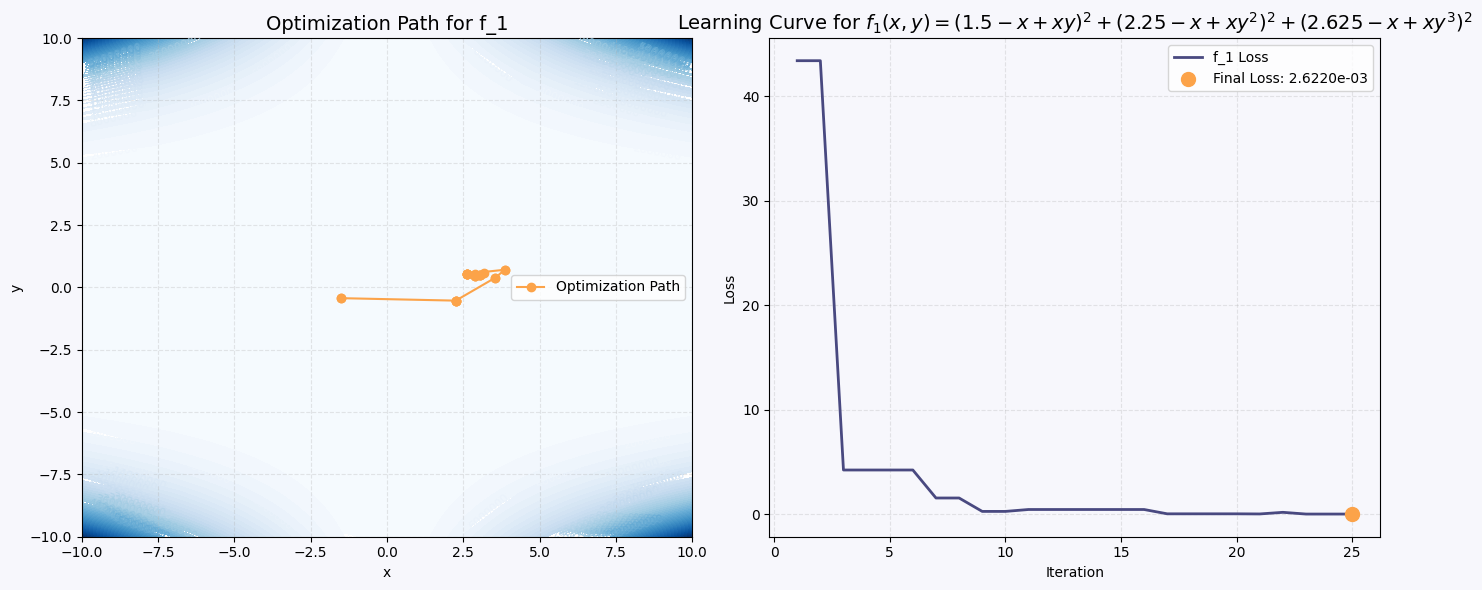

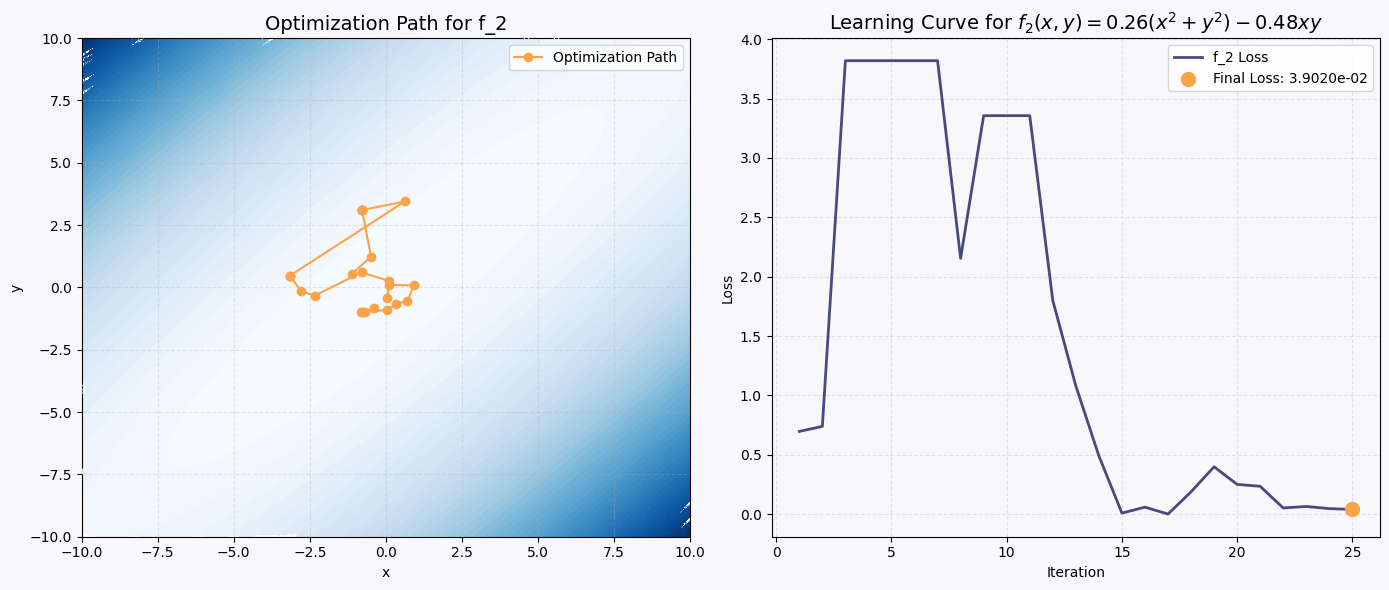

In [86]:
# Contour plots and learning curve with optimization path for RMSprop
print("Contour plots and learning curve with optimization path for RMSprop")
contour_and_learning(RMS_opt)

# Contour plots and learning curve with optimization path for Gradient Descent
print("Contour plots and learning curve with optimization path for Gradient Descent")
contour_and_learning(grad_opt)

# Contour plots and learning curve with optimization path for Simulated Annealing
print("Contour plots and learning curve with optimization path for Simulated Annealing")
contour_and_learning(sa_opt)

##### d) ¿Cómo podría mezclar el algoritmo del descenso del gradiente con el algoritmo de simulated annealing? ¿Qué beneficios tendría el hacerlo?

# FIN

In [87]:
print("Code ends here")

Code ends here
